# Traditional AI Techniques

In [19]:
import os
import sys
import glob
import importlib

# Construct the path
path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
# print(path)
# Add the path to sys.path
sys.path.append(path)
# Change the working directory
os.chdir(path)

# Imports
import pandas as pd
import numpy as np

import tkinter as tk
from tkinter import scrolledtext

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer


from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import Pipeline

In [20]:
# Construct one complete dataset
path = r"C:\Users\HugoP\Desktop\SmartWF-Capstone\Models\Must\\" # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))
li = []

for filename in all_files:
    print(filename)
    df = pd.read_csv(filename, index_col=None, header=0, sep="\t")
    li.append(df)

must_df = pd.concat(li, axis=0, ignore_index=True)
# print(must_df)

C:\Users\HugoP\Desktop\SmartWF-Capstone\Models\Must\DEL_must_model_rep_0.csv
C:\Users\HugoP\Desktop\SmartWF-Capstone\Models\Must\DEL_must_model_rep_2.csv
C:\Users\HugoP\Desktop\SmartWF-Capstone\Models\Must\DEL_must_model_rep_3.csv
C:\Users\HugoP\Desktop\SmartWF-Capstone\Models\Must\DEL_must_model_rep_4_first_part.csv
C:\Users\HugoP\Desktop\SmartWF-Capstone\Models\Must\DEL_must_model_rep_4_second_part.csv
C:\Users\HugoP\Desktop\SmartWF-Capstone\Models\Must\DEL_must_model_rep_5.csv
C:\Users\HugoP\Desktop\SmartWF-Capstone\Models\Must\DEL_must_model_rep_6.csv


# Choose wich target_DEL to train the models on:

In [21]:
# target_DEL = 'Leq_x'
target_DEL = 'Leq_y'
# target_DEL = 'Leq_res'


# Splitting,
Train-Validation-Test

In [22]:
# Split dataset in unique Windspeed-STDeV combinations and repeated combinations
selection_multiple = ((must_df['Windspeed'] >= 15) & (must_df['STDeV'] >= 1.00))
must_df_multiple = must_df[selection_multiple]
must_df_unique = must_df[~selection_multiple]

print("All items in must_df_multiple occur 6 times:",
    (must_df_multiple.groupby(['Windspeed', 'STDeV']).size().reset_index(name='count')['count']==6).all())
print("All items in must_df_unique occur 1 time:",
      (must_df_unique.groupby(['Windspeed', 'STDeV']).size().reset_index(name='count')['count']==1).all())

# Split repeated combinations (3-1-2 distribution at each STDeV value) 
must_df_multiple['stratify_col'] = must_df_multiple['Windspeed'].astype(str) + '_' + must_df_multiple['STDeV'].astype(str)
X_multiple = must_df_multiple[['Windspeed', 'STDeV', 'stratify_col']]
y_multiple = must_df_multiple[target_DEL]

X_train_multiple, X_test_val_multiple, y_train_multiple, y_test_val_multiple = train_test_split(X_multiple, y_multiple, train_size=2/6, stratify=must_df_multiple['stratify_col'])
X_val_multiple, X_test_multiple, y_val_multiple, y_test_multiple = train_test_split(X_test_val_multiple, y_test_val_multiple, test_size=2/4, stratify=X_test_val_multiple['stratify_col'])

# Drop stratify column
X_train_multiple = X_train_multiple.drop(columns=['stratify_col'])
X_test_val_multiple = X_test_val_multiple.drop(columns=['stratify_col'])
X_val_multiple = X_val_multiple.drop(columns=['stratify_col'])
X_test_multiple = X_test_multiple.drop(columns=['stratify_col'])

# Split unique combinations
X_unique = must_df_unique[['Windspeed', 'STDeV']]
y_unique = must_df_unique[target_DEL]

X_train_unique, X_test_val_unique, y_train_unique, y_test_val_unique = train_test_split(X_unique, y_unique,train_size=3/6)
X_val_unique, X_test_unique, y_val_unique, y_test_unique = train_test_split(X_test_val_unique, y_test_val_unique, test_size=2/3)

# Combine to final datasets
X_train = pd.concat((X_train_unique, X_train_multiple))
X_val = pd.concat((X_val_unique, X_val_multiple))
X_test = pd.concat((X_test_unique, X_test_multiple))

y_train = pd.concat((y_train_unique, y_train_multiple))
y_val = pd.concat((y_val_unique, y_val_multiple))
y_test = pd.concat((y_test_unique, y_test_multiple))

train = pd.concat((X_train, y_train), axis=1)
val = pd.concat((X_val, y_val), axis=1)
test = pd.concat((X_test, y_test), axis=1)

train_val_test_dict = {"training": train, "validation": val, "testing":test}

All items in must_df_multiple occur 6 times: True
All items in must_df_unique occur 1 time: True


C:\Users\HugoP\AppData\Local\Temp\ipykernel_6708\1859678950.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  must_df_multiple['stratify_col'] = must_df_multiple['Windspeed'].astype(str) + '_' + must_df_multiple['STDeV'].astype(str)


Training-Test

In [23]:
# Split dataset in unique Windspeed-STDeV combinations and repeated combinations
selection_multiple = ((must_df['Windspeed'] >= 15) & (must_df['STDeV'] >= 1.00))
must_df_multiple = must_df[selection_multiple]
must_df_unique = must_df[~selection_multiple]

print("All items in must_df_multiple occur 6 times:",
    (must_df_multiple.groupby(['Windspeed', 'STDeV']).size().reset_index(name='count')['count']==6).all())
print("All items in must_df_unique occur 1 time:",
      (must_df_unique.groupby(['Windspeed', 'STDeV']).size().reset_index(name='count')['count']==1).all())

# Split repeated combinations (4-2 distribution)
must_df_multiple['stratify_col'] = must_df_multiple['Windspeed'].astype(str) + '_' + must_df_multiple['STDeV'].astype(str)
X_multiple = must_df_multiple[['Windspeed', 'STDeV', 'stratify_col']]
y_multiple = must_df_multiple[target_DEL]

X_train_multiple, X_test_multiple, y_train_multiple, y_test_multiple = train_test_split(X_multiple, y_multiple, test_size=2/6, stratify=must_df_multiple['stratify_col'])

# Drop stratify column
X_train_multiple = X_train_multiple.drop(columns=['stratify_col'])
X_test_multiple = X_test_multiple.drop(columns=['stratify_col'])

# Split unique combinations
X_unique = must_df_unique[['Windspeed', 'STDeV']]
y_unique = must_df_unique[target_DEL]

X_train_unique, X_test_unique, y_train_unique, y_test_unique = train_test_split(X_unique, y_unique,test_size=2/6)

# Combine to final datasets
X_train = pd.concat((X_train_unique, X_train_multiple))
X_test = pd.concat((X_test_unique, X_test_multiple))

y_train = pd.concat((y_train_unique, y_train_multiple))
y_test = pd.concat((y_test_unique, y_test_multiple))

train = pd.concat((X_train, y_train), axis=1)
test = pd.concat((X_test, y_test), axis=1)

train_test_dict = {"training":train, "testing": test}

All items in must_df_multiple occur 6 times: True
All items in must_df_unique occur 1 time: True


C:\Users\HugoP\AppData\Local\Temp\ipykernel_6708\1038652458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  must_df_multiple['stratify_col'] = must_df_multiple['Windspeed'].astype(str) + '_' + must_df_multiple['STDeV'].astype(str)


In [24]:
import tkinter as tk
from tkinter import scrolledtext
# To test whether Test wheter train_test_split happend correctly:
def display_output_in_window(output):
    window = tk.Tk()
    window.title("Output Window")
    text_area = scrolledtext.ScrolledText(window, wrap=tk.WORD, width=200, height=60)
    text_area.pack(padx=10, pady=10)
    text_area.insert(tk.INSERT, output)
    text_area.configure(state='disabled')


# test_sets = {"Training":train, "Validation": val, "Testing": test}
# test_sets = {"Training":X_train, "Validation": X_val, "Testing": X_test}

# test_sets = {"Training":y_train, "Validation": y_val, "Testing": y_test}
# for key, set in train_test_dict.items():
#     set_df = pd.DataFrame(set, columns=['Windspeed', 'STDeV'])
#     set_df = set_df.groupby(['Windspeed', 'STDeV']).size().reset_index(name='count')
#     output = ""
#     output += f"Length {key} set: {len(set_df)}\n"
#     output += set_df.to_string()+"\n"
#     output += f"All samples occur 2 times: {(set_df['count']==2).all()}\n"
#     output += "Combinations which don't occur 1 or 6 times\n"
#     output += set_df[(set_df['count'] != 1) & (set_df['count'] != 6)].to_string() + "\n\n"
#     output += "Combinations which do occur 1 or 6 times\n"
#     output += set_df[(set_df['count'] == 1) | (set_df['count'] == 6)].to_string() + "\n\n"
#     display_output_in_window(output)
# window = tk.Tk()
# window.mainloop()


# Several plot functions

In [25]:
import Models.Must.Traditional_AI_techniques.Plot_data
from Models.Must.Traditional_AI_techniques.Plot_data import *
importlib.reload(Models.Must.Traditional_AI_techniques.Plot_data)

<module 'Models.Must.Traditional_AI_techniques.Plot_data' from 'c:\\Users\\HugoP\\Desktop\\SmartWF-Capstone\\Models\\Must\\Traditional_AI_techniques\\Plot_data.py'>

# KNN

In [36]:
# Input features
train = train_val_test_dict['training']
val = train_val_test_dict['validation']
test = train_val_test_dict['testing']

X_train, y_train = train[['Windspeed', 'STDeV']], train[target_DEL]
X_val, y_val = val[['Windspeed','STDeV']], val[target_DEL]
X_test, y_test = test[['Windspeed', 'STDeV']], test[target_DEL]

In [37]:
# Use standard scaler to get features on the same scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Training without tuning
knn_untuned = KNeighborsRegressor()
knn_untuned.fit(X_train, y_train)
knn_untuned_pred = knn_untuned.predict(X_test)
knn_untuned_mae = mean_absolute_error(y_test, knn_untuned_pred)
print("MAE for default KNN model on test set: ", knn_untuned_mae)

# Training, tuning with GridSearchCV
knn = KNeighborsRegressor()
knn_param_grid = {'n_neighbors': [1,2,3, 5, 10, 15, 16, 17, 18, 20, 50],
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]
                }
 
#scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='neg_mean_absolute_error')
knn_grid_search.fit(X_train, y_train)

print("Best parameters: ", knn_grid_search.best_params_)
knn_best = knn_grid_search.best_estimator_

# Validate the best model using cross_val_score
CV_scores = cross_val_score(knn_best, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Cross-validation scores:", CV_scores)
print("Mean cross-validation score:", CV_scores.mean())

knn_best_pred = knn_best.predict(X_val)
knn_best_mae = mean_absolute_error(y_val, knn_best_pred)
knn_best_mape = mean_absolute_percentage_error(y_val, knn_best_pred)
print("MAE for tuned KNN model on validation set: ", knn_best_mae)
print("Mean absolute percentage error on validation set:", knn_best_mape)


MAE for default KNN model on test set:  7877.098808951726
Best parameters:  {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
Cross-validation scores: [-3835.60746088 -6008.63464812 -8967.61774082 -9368.43790327
 -9019.29278755]
Mean cross-validation score: -7439.918108129568
MAE for tuned KNN model on validation set:  7893.958411573377
Mean absolute percentage error on validation set: 0.08939379413730286


In [38]:
# Rescaling of features
X_train_rescaled = scaler.inverse_transform(X_train)
X_val_rescaled = scaler.inverse_transform(X_val)
X_test_rescaled = scaler.inverse_transform(X_test)

Several plots of result:


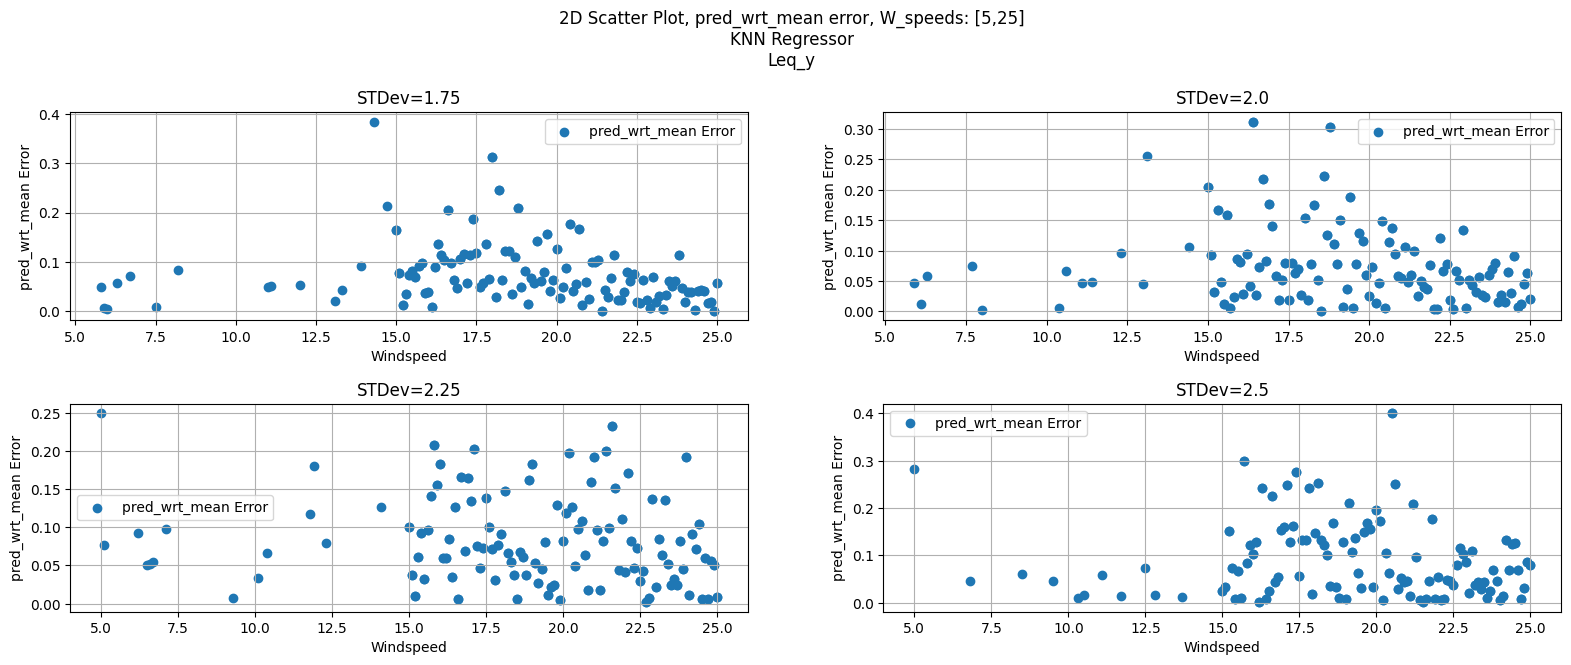

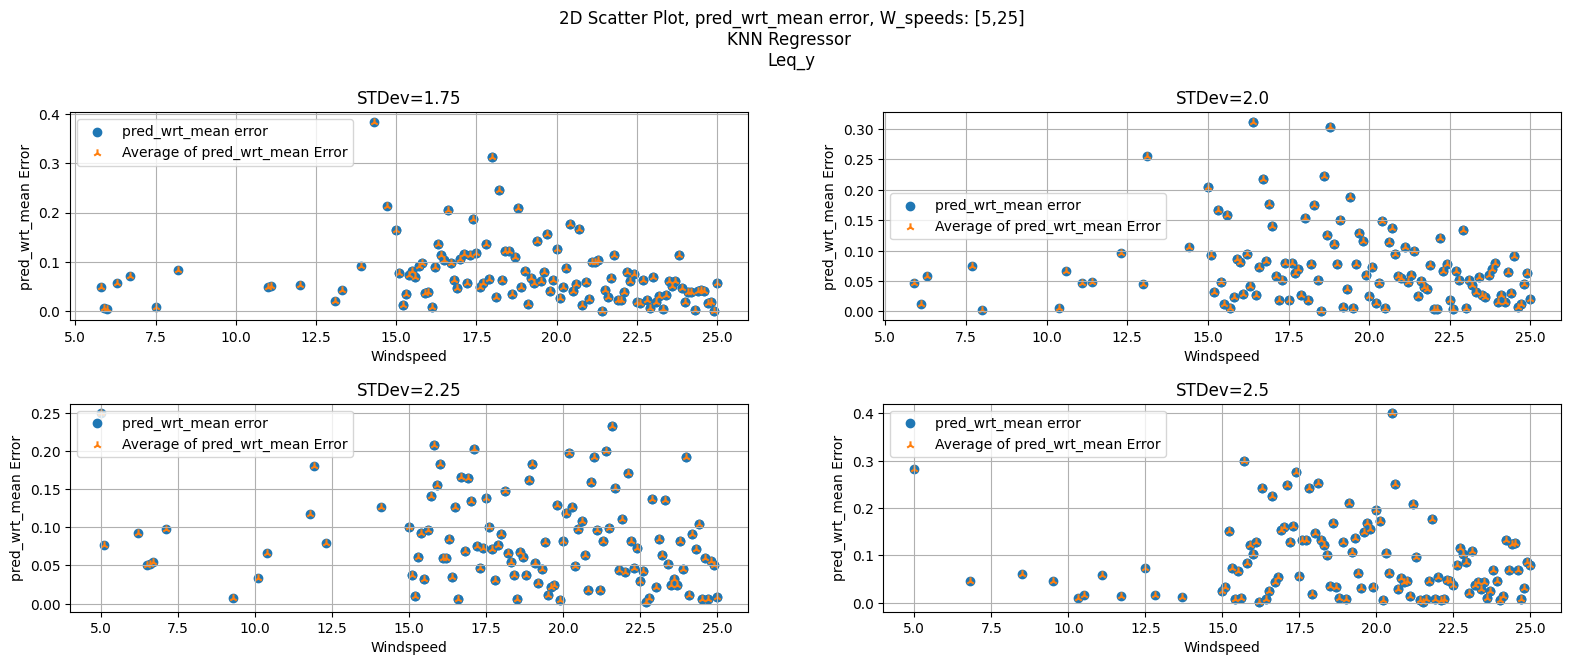

In [86]:
# all_data = pd.DataFrame(np.column_stack((must_df['Windspeed','STDeV'], must_df[target_DEL])), columns=['Windspeed', 'STDeV', 'Leq'])
ground_truth = pd.DataFrame(np.column_stack((X_val_rescaled[:,:2], y_val)), columns=['Windspeed', 'STDeV', 'Leq'])
predictions = pd.DataFrame(np.column_stack((X_val_rescaled[:,:2], knn_best_pred)), columns=['Windspeed', 'STDeV', 'Leq'])

# ground_truth_average = ground_truth.groupby(['Windspeed', 'STDeV'])['Leq'].mean().reset_index()
# predictions_average = predictions.groupby(['Windspeed', 'STDeV'])['Leq'].mean().reset_index()

print("Several plots of result:")
importlib.reload(Models.Must.Traditional_AI_techniques.Plot_data)
from Models.Must.Traditional_AI_techniques.Plot_data import *

# %matplotlib qt
%matplotlib inline
# # Graphs showing predictions and labels
# plot_label_pred_3D(ground_truth, predictions, title=f'KNN Regressor\n{target_DEL}')
# plot_label_pred_2D(ground_truth, predictions, title=f'KNN Regressor\n{target_DEL}',STDeV=all, W_min=5, W_max=25)
# plot_label_pred_2D_mean(ground_truth, predictions, title=f'KNN Regressor\n{target_DEL}', W_min=5, W_max=25)

# # Graphs showing error
# plot_err_3D(ground_truth, predictions, title=f'KNN Regressor\n{target_DEL}', error_type='pred_wrt_mean')
# plot_err_2D(ground_truth, predictions, title=f'KNN Regressor\n{target_DEL}',STDeV=all, error_type='pred_wrt_mean', W_min=5, W_max=25)
# plot_pred_error_2D_mean(ground_truth, predictions, title= f'KNN Regressor \n{target_DEL}', error_type='pred_wrt_mean', W_min=5, W_max=25)

# plot_mean_error(ground_truth, predictions, title=f'KNN Regressor\n{target_DEL}', variant='Windspeed', error_type='pred_wrt_mean')
# plot_mean_error(ground_truth, predictions, title='KNN Regressor\n{target_DEL}', variant='STDeV', error_type='pred_wrt_mean')

plt.show()

In [ ]:
# Plot the final predictions on test dataset:


# Random Forrest


In [332]:
# Since we use crossvalidation, we only need train and test dataset
# Input features
train = train_test_dict['training']
test = train_test_dict['testing']

X_train, y_train = train[['Windspeed', 'STDeV']], train[target_DEL]
X_test, y_test = test[['Windspeed', 'STDeV']], test[target_DEL]

print(X_train.size)
print(X_test.size)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

6448
3228


In [333]:
# Training without tuning
rf_untuned = RandomForestRegressor()
rf_untuned.fit(X_train, y_train)
rf_untuned_pred = rf_untuned.predict(X_test)
rf_untuned_mae = mean_absolute_error(y_test, rf_untuned_pred)
print("MAE for default Random Forest model on test set: ", rf_untuned_mae)

# Training and tuning with GridSearchCV
rf = RandomForestRegressor()
parameters_RF = {'criterion' : ['absolute_error'],
                        'n_estimators': [20, 30, 40, 50],
                        'max_depth' : [5,6, 8, 10],
                        'min_samples_leaf': [3,5, 10]
}
# Best found paramters: {'criterion': 'absolute_error', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 40
rf_grid_search = GridSearchCV(rf, parameters_RF, scoring = 'neg_mean_absolute_error', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

print("Best parameters:", rf_grid_search.best_params_)
rf_best = rf_grid_search.best_estimator_


rf_CV_scores = cross_val_score(rf_best, X_train, y_train, cv=5, scoring = 'neg_mean_absolute_error')
print("Cross-validation scores:", rf_CV_scores)
print("Mean cross validation score:", rf_CV_scores.mean())

rf_best_pred = rf_best.predict(X_test)
rf_best_mae = mean_absolute_error(y_test, rf_best_pred)
print("MAE for tuned Random Forest model on test set: ", knn_best_mae)

MAE for default Random Forest model on test set:  1022.0068214903548
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'criterion': 'absolute_error', 'max_depth': 6, 'min_samples_leaf': 3, 'n_estimators': 50}
Cross-validation scores: [ -302.38441758  -796.48756865  -808.88016811 -1231.11395686
 -1011.8982206 ]
Mean cross validation score: 830.1528663581632
MAE for tuned Random Forest model on test set:  912.72126678138


In [334]:
# Rescaling of features
X_train_rescaled = scaler.inverse_transform(X_train)
X_val_rescaled = scaler.inverse_transform(X_val)
X_test_rescaled = scaler.inverse_transform(X_test)

In [65]:
# Plot result
# all_data = pd.DataFrame(np.column_stack((must_df['Windspeed','STDeV'], must_df[target_DEL])), columns=['Windspeed', 'STDeV', 'Leq'])
ground_truth = pd.DataFrame(np.column_stack((X_test_rescaled[:,:2], y_test)), columns=['Windspeed', 'STDeV', 'Leq'])
predictions = pd.DataFrame(np.column_stack((X_test_rescaled[:,:2], rf_best_pred)), columns=['Windspeed', 'STDeV', 'Leq'])


ground_truth_average = ground_truth.groupby(['Windspeed', 'STDeV'])['Leq'].mean().reset_index()
predictions_average = predictions.groupby(['Windspeed', 'STDeV'])['Leq'].mean().reset_index()

print("Several plots of result:")
importlib.reload(Models.Must.Traditional_AI_techniques.Plot_data)
from Models.Must.Traditional_AI_techniques.Plot_data import *

# %matplotlib qt
%matplotlib inline
# plot_label_pred_3D(ground_truth, predictions, title=f'Random Forest\n{target_DEL}')
# plot_err_3D(ground_truth, predictions, title=f'Random Forest\n{target_DEL}')

# plot_label_pred_2D(ground_truth, predictions, title=f'Random Forest\n{target_DEL}',STDeV=all)
# plot_err_2D(ground_truth, predictions, title=f'Random Forest\n{target_DEL}',STDeV=all, error_type='relative')

# plot_mean_error(ground_truth, predictions, title=f'Random Forest\n{target_DEL}', variant='Windspeed', error_type='relative')
# plot_mean_error(ground_truth, predictions, title='Random Forest\n{target_DEL}', variant='STDeV', error_type='relative')

plot_label_pred_2D_mean(ground_truth, predictions, title=f'Random Forest\n{target_DEL}')
# plot_pred_error_2D_mean(ground_truth, predictions, title= f'Random Forest \n{target_DEL}')
plt.show()


NameError: name 'rf_best_pred' is not defined

# Polynomial Linear Regression

In [322]:
# Since we use cross validation, we only need train and test dataset.
# Input features
train = train_test_dict['training']
test = train_test_dict['testing']

X_train, y_train = train[['Windspeed', 'STDeV']], train[target_DEL]
X_test, y_test = test[['Windspeed', 'STDeV']], test[target_DEL]

print(X_train.size)
print(X_test.size)

6448
3228


In [323]:
# define the pipeline
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures()),
    ('estimator', SGDRegressor())
])

In [324]:
# Training with default parameters
poly_SGD_untuned = pipe
poly_SGD_untuned.fit(X_train, y_train)
poly_SGD_untuned_pred = poly_SGD_untuned.predict(X_test)
poly_SGD_untuned_mae = mean_absolute_error(y_test, poly_SGD_untuned_pred)
print("MAE for default pipeline parameters on test set: ", poly_SGD_untuned_mae)

# Training with GridSearchCV
poly_SGD = pipe
param_grid = {
    'preprocessor__degree': [1, 2, 3, 4, 5, 6, 7, 20],
    'estimator__alpha': [1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'estimator__max_iter': [100, 500, 1000, 2000, 5000, 6000]
}

poly_SGD_grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_absolute_error')
poly_SGD_grid_search.fit(X_train, y_train)

print("Best parameters:", poly_SGD_grid_search.best_params_)
poly_SGD_best = poly_SGD_grid_search.best_estimator_

# Validate the best model using cross_val_score
poly_SGD_CV_scores = cross_val_score(poly_SGD_best, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Cross-validation scores:", poly_SGD_CV_scores)
print("Mean cross-validation score:", poly_SGD_CV_scores.mean())


poly_SGD_best_pred = poly_SGD_best.predict(X_test)
poly_SGD_best_mae = mean_absolute_error(y_test, poly_SGD_best_pred)
print("MAE for tuned Polynomial Regression model on test set: ", poly_SGD_best_mae)

MAE for default pipeline parameters on test set:  971.5299443808258


c:\Users\HugoP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HugoP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HugoP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HugoP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

Best parameters: {'estimator__alpha': 0.01, 'estimator__max_iter': 100, 'preprocessor__degree': 3}
Cross-validation scores: [ -480.92630393  -878.12227423  -844.80947658 -1225.36977883
 -1039.06006815]
Mean cross-validation score: 893.6575803460692
MAE for tuned Polynomial Regression model on test set:  892.7753022265066


In [70]:
# all_data = pd.DataFrame(np.column_stack((must_df['Windspeed','STDeV'], must_df[target_DEL])), columns=['Windspeed', 'STDeV', 'Leq'])
ground_truth = pd.DataFrame(np.column_stack((X_test_rescaled[:,:2], y_test)), columns=['Windspeed', 'STDeV', 'Leq'])
predictions = pd.DataFrame(np.column_stack((X_test_rescaled[:,:2], poly_SGD_best_pred)), columns=['Windspeed', 'STDeV', 'Leq'])


ground_truth_average = ground_truth.groupby(['Windspeed', 'STDeV'])['Leq'].mean().reset_index()
predictions_average = predictions.groupby(['Windspeed', 'STDeV'])['Leq'].mean().reset_index()

print("Several plots of result:")
importlib.reload(Models.Must.Traditional_AI_techniques.Plot_data)
from Models.Must.Traditional_AI_techniques.Plot_data import *

# %matplotlib qt
%matplotlib inline
# plot_label_pred_3D(ground_truth, predictions, title=f'Polynomial feature extraction SGD\n{target_DEL}')
# plot_err_3D(ground_truth, predictions, title=f'Polynomial feature extraction SGD\n{target_DEL}')

# plot_label_pred_2D(ground_truth, predictions, title=f'Polynomial feature extraction SGD\n{target_DEL}',STDeV=all)
# plot_err_2D(ground_truth, predictions, title=f'Polynomial feature extraction SGD\n{target_DEL}',STDeV=all, error_type='relative')

# plot_mean_error(ground_truth, predictions, title=f'Polynomial feature extraction SGD\n{target_DEL}', variant='Windspeed', error_type='relative')
# plot_mean_error(ground_truth, predictions, title='Polynomial feature extraction SGD\n{target_DEL}', variant='STDeV', error_type='relative')

# plot_label_pred_2D_mean(ground_truth, predictions, title=f'Polynomial feature extraction SGD\n{target_DEL}')
plot_pred_error_2D_mean(ground_truth, predictions, title= f'Polynomial feature extraction SGD \n{target_DEL}')
plt.show()

NameError: name 'poly_SGD_best_pred' is not defined